$ \newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|} $
$\newcommand{\au}{\hat{a}^\dagger}$
$\newcommand{\ad}{\hat{a}}$
$\newcommand{\bu}{\hat{b}^\dagger}$
$\newcommand{\bd}{\hat{b}}$
# Cat state encoding
The main goal is to find control pulses which will realise the state transfer:
$$ \underbrace{(c_0\ket{0} + c_1\ket{1})}_{\text{Qubit}}\underbrace{\ket{0}}_{\text{Cavity}} \rightarrow \ket{0}(c_0\ket{C_0} + c_1 \ket{C_1}) $$
where $ \ket{C_0} \propto \ket{-\alpha} + \ket{\alpha} $ is the logical zero and $ \ket{C_1} \propto \ket{-i\alpha} + \ket{i\alpha} $ is the logical one. The method is to optimise such that the six cardinal points on the Bloch sphere realise these cavity cat states and puts the qubit to the ground state.

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
from matplotlib import animation, rc
from IPython.display import HTML

In [31]:
from qutip import *
#from qutip import identity, sigmax, sigmay, sigmaz, sigmam, sigmap, tensor, projection, create, destroy, displace
#from qutip import Qobj, basis, coherent, mesolve, fock
#from qutip import expect
from qutip.superoperator import liouvillian, sprepost
from qutip.qip import hadamard_transform
from qutip.visualization import plot_wigner, plot_wigner_fock_distribution
from qutip.ipynbtools import plot_animation
import qutip.logging_utils as logging
#from qutip import Bloch
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
#log_level = logging.INFO
log_level = logging.WARN
#QuTiP control modules
import qutip.control.pulseoptim as cpo
from numpy import pi, sqrt
file_name = 'Test1'

In [32]:
from time import time

def printTime(start):
    end = time()
    duration = end - start
    if duration < 60:
        return "used: " + str(round(duration, 2)) + "s."
    else:
        mins = int(duration / 60)
        secs = round(duration % 60, 2)
        if mins < 60:
            return "used: " + str(mins) + "m " + str(secs) + "s."
        else:
            hours = int(duration / 3600)
            mins = mins % 60
            return "used: " + str(hours) + "h " + str(mins) + "m " + str(secs) + "s."


# Physics
## Hamiltonian
$$ \hat{H} =  \underbrace{(\omega_a - \chi_{sa}\au\ad)\bu\bd}_{\text{Storage-ancilla coupling}} +\, \omega_s\au\ad  \,-\, \frac{K_s}{2}\au{}^2\ad{}^2 \,-\, \frac{K_a}{2}\bu{}^2\bd{}^2 \,+\, \underbrace{\epsilon_a(t)\bu + \epsilon_a^*(t)\bd}_{\text{Qubit drive}} \,+\, \underbrace{\epsilon_s(t)\au + \epsilon_s^*(t)\ad}_{\text{Res drive}} $$

$$ \bu\bd = \ket{1}\bra{1} = \sigma_-\sigma_+ $$

In [33]:
N = 20 # Hilbert space size
alpha = sqrt(4)

Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Si = identity(2)
Ri = identity(N)
Sm = tensor(sigmam(), Ri)
Sp = tensor(sigmap(), Ri) 
a  = tensor(Si, destroy(N))
b  = Sp



# Hamiltonian - RWA JC, qubit-storage coupling
w_q = 2*pi*6.2815      # Energy of the 2-level system (GHz)
w_r = 2*pi*8.3056      # Resonator freq
chi_qr= 2*pi*1.97e-3     # qubit-storage coupling strength
K_r   = 2*pi*0.45e-3   # Kerr res
K_q   = 2*pi*297e-3    # Kerr qubit 200-300 MHz

#Damping rate:
gamma = 2*pi*2e-6
use_dispersive = True
use_kerr = False

delta = abs(w_r - w_q)    # detuning
g = sqrt(delta * chi_qr)  # coupling strength that is consistent with chi



H_occ = w_r*a.dag()*a + w_q*b.dag()*b

if use_dispersive:
    H_coup = - chi_qr * a.dag()*a * b.dag()*b
else:
    H_coup = g * (a.dag() * b + a * b.dag())

if use_kerr:
    H_kerr = - K_r/2 * a.dag()**2 * a**2 - K_q/2 * b.dag()**2 * b**2
else:
    H_kerr = 0

H0 = H_occ + H_coup + H_kerr


L0 = liouvillian(H0, [np.sqrt(gamma)*b])

#sigma X control
#LC_x = liouvillian(Sx)
#sigma Y control
#LC_y = liouvillian(Sy)
#sigma Z control
#LC_z = liouvillian(Sz)

#Drift
drift = L0
#Controls - 

ctrls = [a.dag(), a, b.dag(), b]


# Starting state
#N_alpha = 1/(2*(1+np.exp(-2*abs(alpha)^2)))
logical_0 = (coherent(N, alpha) + coherent(N,-alpha)).unit()
logical_1 = (coherent(N, alpha*1j) + coherent(N,-alpha*1j)).unit()
phi = tensor(basis(2,1), basis(N,0))
#print(phi)
#print(res_targ_0)
# target for map evolution
phi_targ = tensor(basis(2,0), basis(N,0))

# System check
Some tests to see if the system is setup correctly

Is $\Delta \gg g$?

In [34]:
delta/g

32.05404699775068

## Time evolution

In [35]:
#psi0 = tensor(basis(2,1), basis(N,0))
psi0 = tensor((basis(2,0)+basis(2,1).unit()), coherent(N,2))
#psi0 = tensor(basis(2,0), basis(N,4))
t_tot = 10
tlist = np.linspace(0,t_tot,10)
decay = False
if decay:
    rate = [np.sqrt(gamma) * b]
else:
    rate = []
res = mesolve(H0, psi0, tlist, rate, [],options=Odeoptions(nsteps=10000),progress_bar=True)

10.0%. Run time:   0.10s. Est. time left: 00:00:00:00
20.0%. Run time:   0.20s. Est. time left: 00:00:00:00
30.0%. Run time:   0.29s. Est. time left: 00:00:00:00
40.0%. Run time:   0.39s. Est. time left: 00:00:00:00
50.0%. Run time:   0.48s. Est. time left: 00:00:00:00
60.0%. Run time:   0.57s. Est. time left: 00:00:00:00
70.0%. Run time:   0.66s. Est. time left: 00:00:00:00
80.0%. Run time:   0.75s. Est. time left: 00:00:00:00
90.0%. Run time:   0.85s. Est. time left: 00:00:00:00
Total run time:   0.85s


### Expectation values

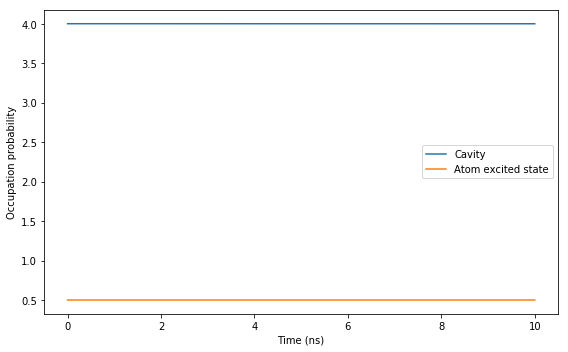

In [36]:
nc_list = expect(a.dag()*a, res.states)
nq_list = expect(b.dag()*b, res.states)

fig, ax = plt.subplots(sharex=True,figsize=(8,5))
ax.plot(tlist, nc_list, label="Cavity")
ax.plot(tlist, nq_list, label="Atom excited state")
ax.legend()
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Occupation probability');
fig.tight_layout()

### Cavity quadratures

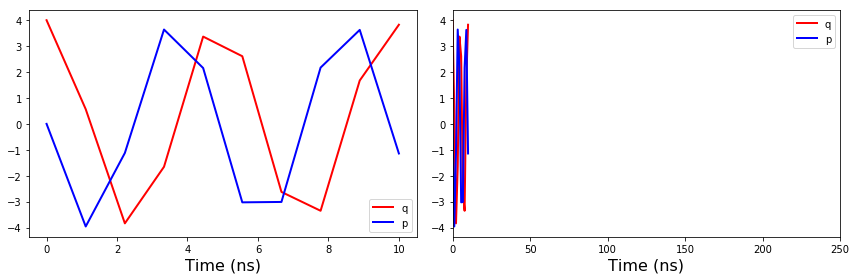

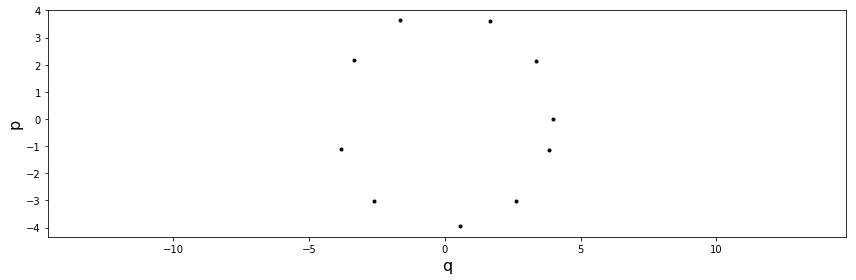

In [37]:
xc_list = expect((a + a.dag()), res.states)
yc_list = expect(-1j*(a - a.dag()), res.states)

fig, [ax,ax2] = plt.subplots(1,2,sharex=False, figsize=(12,4))

ax.plot(tlist, xc_list, 'r', linewidth=2, label="q")
ax.plot(tlist, yc_list, 'b', linewidth=2, label="p")
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()

ax2.plot(tlist, xc_list, 'r', linewidth=2, label="q")
ax2.plot(tlist, yc_list, 'b', linewidth=2, label="p")
ax2.set_xlabel("Time (ns)", fontsize=16)
ax2.set_xlim(0,250)
ax2.legend()
fig.tight_layout()

fig, ax = plt.subplots(1,1,sharex=False, figsize=(12,4))

ax.plot(xc_list,yc_list, 'k.', linewidth=2, label="q")
ax.set_xlabel("q", fontsize=16)
ax.set_ylabel("p", fontsize=16)
ax.axis('equal')
fig.tight_layout()

### Spectrum of resonator and qubit

In [199]:
tlist2 = np.linspace(0, 1000, 1000)
start = time()
corr_vec = correlation_2op_2t(H0, psi0, None, tlist2, [], a.dag(), a, solver='me',options=Odeoptions(nsteps=5000))
elapsed = printTime(start)
print(elapsed)
w, S = spectrum_correlation_fft(tlist2, corr_vec)

used: 11m 26.7s.


In [201]:
print(elapsed)

used: 11m 26.7s.


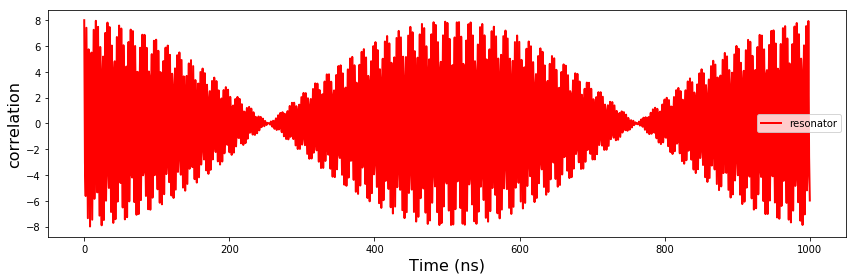

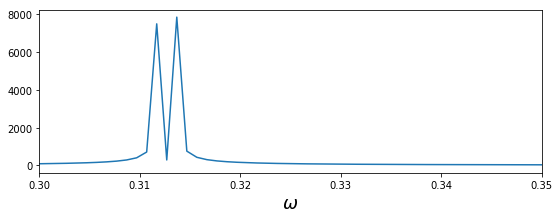

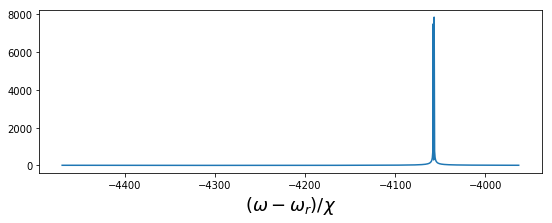

In [205]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist2, np.real(corr_vec), 'r', linewidth=2, label="resonator")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
#ax.set_xlim(0,100)
fig.tight_layout()

fig, ax = plt.subplots(figsize=(9,3))
ax.plot(w / (2 * pi), abs(S))
ax.set_xlabel(r'$\omega$', fontsize=18)
ax.set_xlim(0.3,0.35)
#ax.set_xlim(w_r/(2*pi)-.5, w_r/(2*pi)+.5);

fig, ax = plt.subplots(figsize=(9,3))
ax.plot((w-w_r)/chi_qr, abs(S))
ax.set_xlabel(r'$(\omega-\omega_r)/\chi$', fontsize=18);
#ax.set_xlim(-5080,-5070);

In [210]:
plot_animation(plot_setup, plot_result, result)

NameError: name 'plot_animation' is not defined

In [ ]:
def plot_wigners(states):
    #f = plt.figure(figsize=(6*len(states), 6))
    for i, state in enumerate(states):
        #a = f.add_subplot(1,len(states),i+1)
        plot_wigner_fock_distribution(state,)#fig=f,ax = a)
        #a.axis('equal')

#states = [phi, phi_targ]
#qubit_states = [s.ptrace(0) for s in states]
#res_states = [s.ptrace(1) for s in states]
#plot_wigners(qubit_states)
#plot_wigners(res_states)


In [ ]:
# Time slot length
l_ts = 1
# Time allowed for the evolution (nanosec)
evo_time = 500
# Number of time slots
n_ts = int(evo_time//l_ts + 1)

In [ ]:
# Fidelity error target
fid_err_targ = 1e-3
# Maximum iterations for the optisation algorithm
max_iter = 200
# Maximum (elapsed) time allowed in seconds
max_wall_time = 60*1
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'RND'
#Set to None to suppress output files
#f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)
f_ext = None

In [ ]:
result = cpo.optimize_pulse(drift, ctrls, phi, phi_targ, n_ts, evo_time, 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                out_file_ext=f_ext, init_pulse_type=p_type, 
                log_level=log_level, gen_stats=True)
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(datetime.timedelta(seconds=result.wall_time)))

In [ ]:
states = [phi, phi_targ, result.evo_full_final]
qubit_states = [s.ptrace(0) for s in states]
res_states = [s.ptrace(1) for s in states]
plot_wigners(qubit_states + res_states)

In [ ]:
def plot_control_pulses(result):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(2, 1, 1)
    ax1.set_title("Initial control amps")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Control amplitude")
    ax2 = fig1.add_subplot(2, 1, 2)
    ax2.set_title("Optimised Control Sequences")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Control amplitude")
    for i in range(len(ctrls)):
        ax1.step(result.time, 
                 np.hstack((result.initial_amps[:, i], result.initial_amps[-1, i])), 
                 where='post')
        ax2.step(result.time, 
         np.hstack((result.final_amps[:, i], result.final_amps[-1, i])), 
         where='post')
    fig1.tight_layout()
    
plot_control_pulses(result)